# 07 Pytorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiments are worth pursuing, that's where **Experiment Tracking** comes in, it helps you to figure out what does not work so you can figure out what does work

In this notebook, we're going to see an example of programatically tracking experiments.

In [12]:
import torch 
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [13]:
# continue with regular imports 
import matplotlib.pyplot as plt 
import torch 
import torchvision
from torchvision import transforms

from timeit import default_timer as timer

from tqdm.auto import tqdm 

from torchinfo import summary
from going_modular import data_setup, engine, utils

In [14]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

Want to get pizza, steak, sushi images.

So we can run experiments building FoodVision Mini and see which model performs best.

In [15]:
import os 
import zipfile 
from pathlib import Path
import requests

def download_data(source: str,
                 destination: str,
                 remove_source: bool = True) -> Path:

    """
    Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): link where data is present.
        destination (str): Where to put the unzipped data.
        remove_source (bool, optional): Whether or not remove the source file or not ? Default=True
    """
    # Setup path to data folder
    data_path = Path('data/')
    image_path = data_path / destination

    # If the image folder does not exist create it
    if image_path.is_dir():
        print(f'[INFO] {image_path} directory already exist.. skipping download')
    else:
        print(f'[INFO] Did not find image path and directory, creating one....')
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print(f'[INFO] Downloading {target_file} from {source}.....')
            f.write(request.content)

        # Unzip target file 
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f'[INFO] Unzipping {target_file} data....')
            zip_ref.extractall(image_path)

        # Remove .zip file if needed

        if remove_source:
            os.remove(data_path / target_file)

    return image_path

source = r"https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

In [16]:
image_path = download_data(source=source,
                          destination='pizza_steak_sushi')
image_path

[INFO] data\pizza_steak_sushi directory already exist.. skipping download


WindowsPath('data/pizza_steak_sushi')

## 2. Creating Datasets and Dataloaders

### 2.1 Create DataLoaders with manual transforms

The goal with transform is to ensure your custom data is formatted in a reproducible way as well as a way that will suit pretrained models.


In [17]:
# Setup directories
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [18]:
# Define the ImageNet normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f'Manually created transforms: {manual_transforms}')

# Create DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1f6b449f0a0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

The same principle applies for automatic transform: we want our custom data in the same format as a pretrained model was trained on?

In [19]:
# Setup dirs
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Setup pretrained weights (plenty of these weights available online (in torchvision.models))
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
automatic_transforms = weights.transforms()
print(f'Automatically created transforms: {automatic_transforms}')

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1f6b449ec20>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained a model, freeze base layers and change classifier head

In [20]:
# getting a pretrained model
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [21]:
# Let's change the classifier head that suits to our problem
from torch import nn
utils.set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3)
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [22]:
# Freeze the base layers
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
summary(model, input_size=[1, 3, 224, 224],
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train a single model and track results

In [24]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To track experiments, we're going to use TensorBoard

To interact with TensorBoard we can use PyTorch's SummaryWriter

In [14]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer

In [15]:
from going_modular.engine import train_step, test_step
from typing import List, Tuple, Dict
from tqdm.auto import tqdm


In [16]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ## New: Experiment Tracking ### 
        writer.add_scalars(main_tag='Loss',
                         tag_scalar_dict={'train_loss': train_loss,
                                         'test_loss': test_loss},
                         global_step=epoch)

        writer.add_scalars(main_tag='Accuracy',
                         tag_scalar_dict={'train_acc': train_acc,
                                         'test_acc': test_acc},
                         global_step=epoch)

        writer.add_graph(model=model,
                        input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the write
    writer.close()
    ### End New ###

    # Return the filled results at the end of the epochs
    return results


In [17]:
# Train model
# Note: not using engine.train(), since we updated the train function above

utils.set_seeds()
results = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device,
               epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.3750 | test_loss: 0.9135 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.9017 | train_acc: 0.6484 | test_loss: 0.7943 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.8139 | train_acc: 0.7266 | test_loss: 0.6804 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.6793 | train_acc: 0.7188 | test_loss: 0.6745 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.7114 | train_acc: 0.7266 | test_loss: 0.6813 | test_acc: 0.7737


In [18]:
results

{'train_loss': [1.0977561250329018,
  0.9016556218266487,
  0.8138723522424698,
  0.6793194711208344,
  0.7113911211490631],
 'train_acc': [0.375, 0.6484375, 0.7265625, 0.71875, 0.7265625],
 'test_loss': [0.9135277072588602,
  0.7943447430928549,
  0.6804186701774597,
  0.6744821667671204,
  0.6812925338745117],
 'test_acc': [0.5501893939393939,
  0.8257575757575758,
  0.8759469696969697,
  0.8352272727272728,
  0.7736742424242425]}

## 5. View our model's results with TensorBoard

There are few ways to view results on tensorboard.

In [19]:
# Let's view our experiments from within the notebook
%reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 21048), started 3:36:57 ago. (Use '!kill 21048' to kill it.)

## 6. Create a function to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` class saves to 'log_dir'.

How about if we wanted to save different experiments to different folders? 

In essence, one experiment = one folder.

For example, we'd like to track:
* Experiment data/timestamp
* Experiment name
* Model name 
* Extra - is there anything else that should be tracked.

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [20]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    """Creates a torch.utils.tensorboard.writer.SummaryWRiter() instance tracking to a specific directory"""
    from datetime import datetime
    import os 

    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        # Create log directory path
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
    print(f'[INFO] Created SummaryWriter saving to {log_dir}')
    
    return SummaryWriter(log_dir=log_dir)

In [21]:
example_writer = create_writer(experiment_name='data_10_percent',
                              model_name='effnetb0',
                              extra='5_epohcs')
example_writer

[INFO] Created SummaryWriter saving to runs\2025-07-21\data_10_percent\effnetb0\5_epohcs


### 6.1 Update the `train()` function to include a `writer` parameter.

In [22]:
# Update train() to use create writer().
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ## New: Experiment Tracking ### 
        if writer:
            writer.add_scalars(main_tag='Loss',
                             tag_scalar_dict={'train_loss': train_loss,
                                             'test_loss': test_loss},
                             global_step=epoch)
    
            writer.add_scalars(main_tag='Accuracy',
                             tag_scalar_dict={'train_acc': train_acc,
                                             'test_acc': test_acc},
                             global_step=epoch)
    
            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))

            # Close the write
            writer.close()
        else:
            pass
    ### End New ###

    # Return the filled results at the end of the epochs
    return results


## 7. Setting up a series of modelling experiments

* setup 2x modelling experiments with effnetb0, pizza, steak, sushi data and train one model for 5 epochs and another model with 10 epochs

### 7.1 What kind of experiments should you run?

The number of machine learning experiments you can run, is like the number of different models you can build....almost limitless..

However, you can't test everythin...

So what should you test?
* Change the number of epochs
* Change the number of hidden layers/units
* Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architecture

This is why transfer learning is so powerful, because it's a working model you can apply on your working problem.

### 7.2 What experiments are we going to run? 

We're going to turn 3 dials:
1. Model size - Effnetb0 vs EffnetB2
2. Dataset size - 10 % of data vs 20 % of data
3. Training time - 5 epochs vs 10 epochs

To begin, we're still keeping things small so that our experiments run quickly.

Our goal: a model that is well performing but still small enough to run on a mobile device or web browser, so FoodVisionMINI can come to life.

If you had infinite compute + time, you should basically always choose the biggest model and biggest dataset you can.


### 7.3 Download different datasets.

We want two Datasets:

1. Pizza, Steak, sushi 10%
2. Pizza, Steak, sushi 20%


In [32]:
# download 10 percent and 20 percent datasets

data_10_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                    destination='pizza_steak_sushi')
data_20_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                                    destination='pizza_steak_sushi_20_percent')

[INFO] data\pizza_steak_sushi directory already exist.. skipping download
[INFO] data\pizza_steak_sushi_20_percent directory already exist.. skipping download


### 7.4 Transform Datasets and Create DataLoaders

we'll need to transform our data in few ways.

1. Resize the images(224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [24]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'

# Setup test directory path (We are using the same test data)
test_dir = data_10_percent_path / 'test'

train_dir_10_percent, train_dir_20_percent, test_dir


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [25]:
from torchvision import transforms

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [26]:
BATCH_SIZE = 32

# Create 10% training and test dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% traning and test dataloaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

print(f'Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}')
print(f'Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_20_percent)}')
print(f'Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}')
print(f'Class names: {class_names}')


Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 10% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We want two functions:
1. Creates a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/ base layers and a custom classfier head.
2. Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/ base layers and a custom classfier head.

In [27]:
import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
#effnetb2

In [28]:
summary(model=effnetb2,
       input_size=(32, 3, 224 , 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1408, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    │    └─MBConv: 3-5                                 [32, 16, 112, 112]        612
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-6                                

In [25]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False 

    # Change the classfier head 
    from going_modular.utils import set_seeds
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = 'effnetb0'
    print(f'[INFO] Created new {model.name} model...')
    return model


# Create an EffNetB2 feature extractor
def create_effnetb2():
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False 

    # Change the classfier head 
    from going_modular.utils import set_seeds
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = 'effnetb2'
    print(f'[INFO] Created new {model.name} model...')
    return model



In [30]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()


[INFO] Created new effnetb2 model...
[INFO] Created new effnetb0 model...


In [31]:
summary(model=created_model_test_effnetb0,
       input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 3]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

### 7.6 Create experiments and set up training code

In [32]:
# Create epoch list 
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ['effnetb0', 'effnetb2']

# Create a DataLoaders dictionary
train_dataloaders = {'data_10_percent': train_dataloader_10_percent,
                    'data_20_percent': train_dataloader_20_percent}



In [33]:
!nvidia-smi

Mon Jul 21 16:10:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   62C    P0             21W /   50W |    1825MiB /   4096MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
%%time 
from going_modular.utils import save_model, set_seeds


# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:

            # Print out info
            experiment_number += 1
            print(f'[INFO] Experiment number: {experiment_number}')
            print(f'[INFO] Model: {model_name}')
            print(f'[INFO] DataLoader: {dataloader_name}')
            print(f'[INFO] Number of epochs: {epochs}')

            # Select and create the model
            if model_name == 'effnetb0':
                model = create_effnetb0().to(device)
            else:
                model = create_effnetb2().to(device)

            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(),
                                        lr=0.001)

            # Train target model with target dataloader and track experiments
            # Using train() rather than engine.train()
            train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 device=device,
                 epochs=epochs,
                 writer=create_writer(experiment_name=dataloader_name,
                                     model_name=model_name,
                                     extra=f'{epochs}_epochs'))
            # Save the model to file so we can import it later if need be
            save_filepath = f'07_{model_name}_{dataloader_name}_{epochs}_epochs.pth'
            save_model(model=model,
                      target_dir='models',
                      model_name=save_filepath)
            print('-'*50 + '\n')


[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2025-07-21\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0345 | train_acc: 0.4883 | test_loss: 0.9160 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9488 | train_acc: 0.5156 | test_loss: 0.8308 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8247 | train_acc: 0.6758 | test_loss: 0.7256 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7138 | train_acc: 0.7734 | test_loss: 0.6168 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6176 | train_acc: 0.9023 | test_loss: 0.5833 | test_acc: 0.8968
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2025-07-21\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3594 | test_loss: 0.9597 | test_acc: 0.6193
Epoch: 2 | train_loss: 0.9005 | train_acc: 0.6133 | test_loss: 0.9017 | test_acc: 0.6619
Epoch: 3 | train_loss: 0.8439 | train_acc: 0.6680 | test_loss: 0.8033 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7016 | train_acc: 0.8633 | test_loss: 0.6889 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7045 | train_acc: 0.7461 | test_loss: 0.6449 | test_acc: 0.8968
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2025-07-21\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0345 | train_acc: 0.4883 | test_loss: 0.9160 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9488 | train_acc: 0.5156 | test_loss: 0.8308 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8247 | train_acc: 0.6758 | test_loss: 0.7256 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7138 | train_acc: 0.7734 | test_loss: 0.6168 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6176 | train_acc: 0.9023 | test_loss: 0.5833 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5468 | train_acc: 0.8828 | test_loss: 0.5930 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6351 | train_acc: 0.7227 | test_loss: 0.5944 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5062 | train_acc: 0.8125 | test_loss: 0.5404 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4694 | train_acc: 0.9141 | test_loss: 0.5323 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.5745 | train_acc: 0.7383 | test_loss: 0.4892 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3594 | test_loss: 0.9597 | test_acc: 0.6193
Epoch: 2 | train_loss: 0.9005 | train_acc: 0.6133 | test_loss: 0.9017 | test_acc: 0.6619
Epoch: 3 | train_loss: 0.8439 | train_acc: 0.6680 | test_loss: 0.8033 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7016 | train_acc: 0.8633 | test_loss: 0.6889 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7045 | train_acc: 0.7461 | test_loss: 0.6449 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5914 | train_acc: 0.8945 | test_loss: 0.6555 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6105 | train_acc: 0.8125 | test_loss: 0.6009 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5183 | train_acc: 0.8164 | test_loss: 0.5960 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5067 | train_acc: 0.9258 | test_loss: 0.5544 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.5215 | train_acc: 0.8086 | test_loss: 0.5404 | test_acc: 0.9081
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9658 | train_acc: 0.6021 | test_loss: 0.6651 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6957 | train_acc: 0.7750 | test_loss: 0.5853 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5878 | train_acc: 0.8438 | test_loss: 0.5044 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4584 | train_acc: 0.9062 | test_loss: 0.4225 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4601 | train_acc: 0.8500 | test_loss: 0.3884 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2025-07-21\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9847 | train_acc: 0.5396 | test_loss: 0.7874 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7176 | train_acc: 0.7812 | test_loss: 0.6635 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5817 | train_acc: 0.8958 | test_loss: 0.5616 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5356 | train_acc: 0.8542 | test_loss: 0.5166 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4638 | train_acc: 0.8729 | test_loss: 0.4510 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2025-07-21\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9658 | train_acc: 0.6021 | test_loss: 0.6651 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6957 | train_acc: 0.7750 | test_loss: 0.5853 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5878 | train_acc: 0.8438 | test_loss: 0.5044 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4584 | train_acc: 0.9062 | test_loss: 0.4225 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4601 | train_acc: 0.8500 | test_loss: 0.3884 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4174 | train_acc: 0.8896 | test_loss: 0.3737 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3933 | train_acc: 0.8625 | test_loss: 0.3392 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3464 | train_acc: 0.8917 | test_loss: 0.3504 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3715 | train_acc: 0.9021 | test_loss: 0.3439 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3756 | train_acc: 0.8875 | test_loss: 0.2868 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9847 | train_acc: 0.5396 | test_loss: 0.7874 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7176 | train_acc: 0.7812 | test_loss: 0.6635 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5817 | train_acc: 0.8958 | test_loss: 0.5616 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5356 | train_acc: 0.8542 | test_loss: 0.5166 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4638 | train_acc: 0.8729 | test_loss: 0.4510 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3849 | train_acc: 0.9000 | test_loss: 0.4630 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3604 | train_acc: 0.9021 | test_loss: 0.4290 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3297 | train_acc: 0.8917 | test_loss: 0.4202 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3540 | train_acc: 0.8875 | test_loss: 0.4390 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3630 | train_acc: 0.8729 | test_loss: 0.3771 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in TensorBoard

We've *experiment, experiment, experiment!*

Now let's visualize, visualize, visualize

In [9]:
# Let's view our expermiments from within notebook

%load_ext tensorboard
%tensorboard --logdir=runs --port=6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The best performance model was:
* Model: EffNetB2
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

And the overall trend of all the results was that more data, bigger model and longer training time generally led to better results.

## 9. Load the best model and make predictions with it.

In [27]:
# Setup best model filepath
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'

# Instantiate a new instance of effnetb2
best_model = create_effnetb2()

# Load the saved best model state_dict
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


C:\Users\yashs\AppData\Local\Temp\ipykernel_8160\2868845321.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

Our goal: create a FoodVision MINI model that performs well enough and is able to run on a mobile device/web browser.

In [28]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes and then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f'EfficientNetB2 feature extracter model size: {effnetb2_model_size} MB')

EfficientNetB2 feature extracter model size: 29 MB


In [29]:
# Import function to make prediction on images and plot them.

from going_modular.predictions import pred_and_plot_image

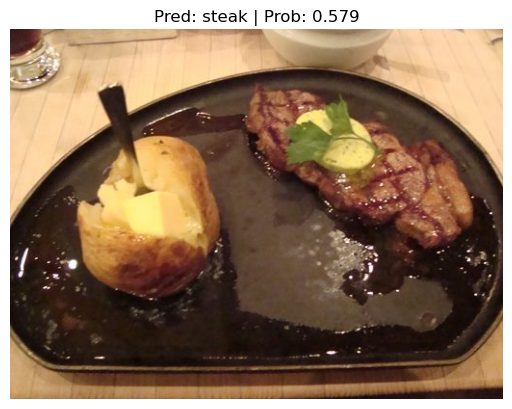

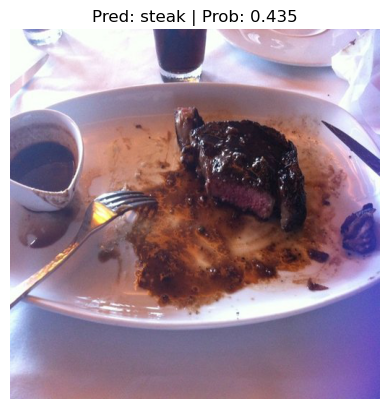

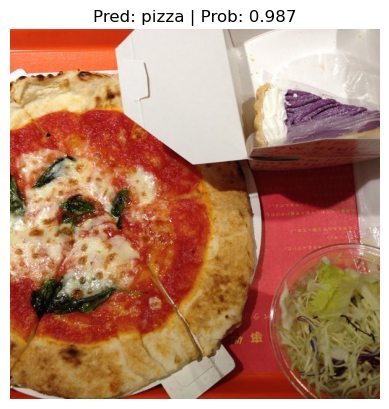

In [36]:
# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / 'test').glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                      k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224, 224))

### 9.1 Predict on a custom image with the best model

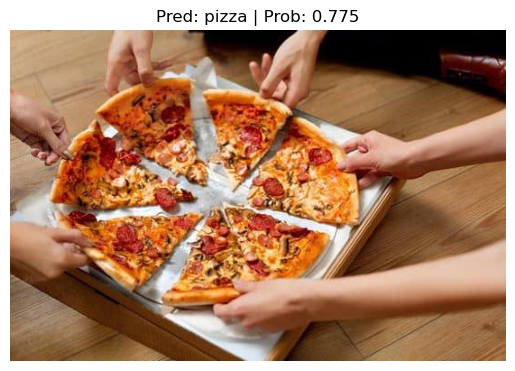

In [41]:
custom_image_path = 'data/pizza.jpeg'
pred_and_plot_image(model=best_model,
                   image_path=custom_image_path,
                   class_names=class_names)


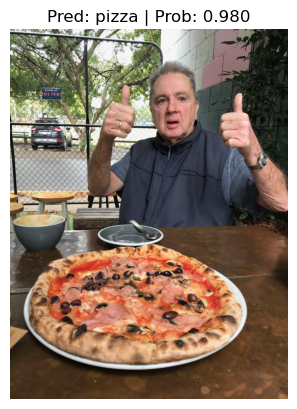

In [44]:
custom_image_path = 'data/04-pizza-dad.jpeg'
pred_and_plot_image(model=best_model,
                   image_path=custom_image_path,
                   class_names=class_names)
